In [3]:
import configparser

parser = configparser.ConfigParser()
parser.read('config.ini')

['config.ini']

# libs & formatting 

In [4]:
import sys
import pandas as pd
import numpy as np
import os
import traceback
import pdb
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import json
import scipy
from scipy import signal
import functools as ftl

np.seterr(all="ignore")

#--- user libs
sys.path.append(parser['py library directory']['path'])
import utility as utl
import imp
imp.reload(utl)
import LammpsPostProcess2nd as lp
imp.reload(lp)

class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
            'linewidth':1, 
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs
    
DRAW_FRAME=(0.23,0.08,0.12,0.07,0.1)
if not eval(parser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Avalanche statistics
## class Statistics

In [152]:
class Statistics:
    pref = 1e-4 #--- bar to GPA
    def __init__(self,path,verbose=False):

        self.path = path
        self.verbose = verbose
        
        #--- list of files
        self.inputFiles = os.listdir('%s'%(path))
        if self.verbose:
            print('class Statistics constructor call: inputFiles=',np.array(self.inputFiles))
            
            
    def ParseDump(self,fp):
        if self.verbose:
            print('parsing %s/%s:'%(self.path,fp))
        self.lmpData = lp.ReadDumpFile('%s/%s'%(self.path,fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            display(self.lmpData.coord_atoms_broken[keys[0]])
            
    def GetStressDump(self):
        '''
        return stress timeseries from dump file
        '''
        #--- timesteps
        keys = list(self.lmpData.coord_atoms_broken.keys())
        keys.sort()

        #--- virial
        szz = np.array(list(map(lambda x:self.lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys)))

        #--- volume
        vol = np.array(list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=self.lmpData.BoxBounds[x],
                                                     AddMissing=np.array([0,0,0])).CellVector),
                       keys)))

        ezz = Statistics.Strain(self.lmpData)
        self.dmpStrs=pd.DataFrame(np.c_[keys,ezz,Statistics.pref*szz/vol,szz],
                                  columns=['timestep','strain','szz','virial'])

    
    def ParseTimeSeries(self,fp,
                        max_rows=1000000,
                        skiprows=0,
                        cols=['timestep']):    
        if self.verbose:
            print('parsing %s/%s:'%(self.path,fp))
        self.loadTimeSeries=pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(self.path,fp),max_rows=max_rows,skiprows=skiprows)],
                        columns=cols,
                                   )
        self.loadTimeSeriesOriginal = self.loadTimeSeries.copy()
        #--- add timesteps: thermo.txt must include every timestep!
#         n=loadTimeSeries.shape[0]
#         self.loadTimeSeries=pd.DataFrame(np.c_[range(n),loadTimeSeries],
#                                          columns = ['timestep']+list(loadTimeSeries.keys()))
        
    def PltTimeSeries(self,ld, xdata='strain',ydata='szz',
                      **kwargs):
        !mkdir png

        #--- set limits

        #--- time
        tlo = ld[xdata].min() if not 'xlim' in kwargs else kwargs['xlim'][0]
        thi = ld[xdata].max() if not 'xlim' in kwargs else kwargs['xlim'][1] #ld.Time.max()
        filtr=np.all([ld[xdata]<thi,ld[xdata]>=tlo],axis=0)
#         # #--- load
        flo = 0.99*ld[ydata][filtr].min()
        fhi = 1.01*ld[ydata][filtr].max() 

        #--- rate
        rate = -np.gradient(ld[ydata],ld[xdata])
        filtr = np.all([filtr,rate > 0],axis=0)
        rlo = 0.99*rate[filtr].min()
        rhi = 1.01*rate[filtr].max() 


        ax=utl.PltErr(None,None,Plot=False)

        utl.PltErr(ld[xdata][filtr], rate[filtr],
                   attrs={'fmt':'.','color':'red','ms':.4},
                    Plot=False,
                      ax=ax,
        #           yscale='log',
#                    xlim=(tlo,thi),
                    ylim=kwargs['ylim'] if 'ylim' in kwargs else (rlo,rhi),

                  )

        #--- load vs. time
        utl.PltErr(ld[xdata], ld[ydata],
                   attrs={'fmt':'-','color':'C0'},
        #             Plot=False,
#                    xlim=(tlo,thi),
                   ylim=kwargs['ylim'] if 'ylim' in kwargs else (flo,fhi),
                   ax=ax,
                      twinx=True,
#                    title='png/stress_timeseries.png',
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
    @staticmethod
    def GetAvl( t,x, y, lambdc ):
        n = len(x)
        i = 0
        smat = [[],[],[],[],[]]
        try:
            while True:
                while y[i] < lambdc:
                    i += 1
                assert y[i] >= lambdc
                #--- avalanche starts
                dur = 0
    #            size = 0.0 #y[i]
                start = x[i]
                start_indx = i
                start_t = t[i]
                while y[i]>=lambdc: #-x[i] == 1:
                    dur += 1
    #                size += (y[i]-lambdc)
                    i += 1
                #--- avalanche ends
                assert y[i] < lambdc
                end = x[i] #x[i-1 if i-1 >= 0 else 0]
                end_indx = i #i-1 if i-1>= 0 else 0
                end_t = t[i] #i-1 if i-1>= 0 else 0
                #--- size
                sub_x = x[start_indx:end_indx+1]
                sub_y = y[start_indx:end_indx+1]
                size = np.sum((sub_x[1:]-sub_x[:-1])*sub_y[:-1])
    #            print start, end, size
                #--- find epicenter
                smat = np.c_[smat,[start, end, start_t, end_t, size]]
        except:
    #        traceback.print_exc()
            pass

        assert smat.shape[1] > 0, 'Lower lambdc! lambdc='%lambdc
        df_avl = pd.DataFrame(smat.T,columns=['ei','ef','ti','tf','size'])
        df_avl=df_avl[df_avl['size']>0]
        return df_avl
    
    @staticmethod
    def Wrapper_GetAvl(t,x,y,tlo,thi,lambdc):
        '''
        return avalanche sizes given force timeseries and initial and final times
        '''

#        pdb.set_trace()

        signal = -np.gradient(y,x)
        if lambdc == 'median':
            filtr = signal > 0
            lambdc = np.median(signal[filtr])
            print('threshold=',lambdc)
        df_avl = Statistics.GetAvl( t,np.array(x), signal, lambdc)
        df_avl.sort_values( by = 'ti',ascending = True,inplace=True)

        #--- data frame storing avalanche attributes
        filtr = np.all([df_avl.ei>=tlo,df_avl.ef<thi],axis=0)

        return df_avl[filtr]
    
    def Avalanche(self, ld, xdata='strain',value='szz',    
        lambdc = 0.0, #--- threshold
        **kwargs
                 ):
        tlo = ld[xdata].min() if not 'strain_lo' in kwargs else kwargs['strain_lo']
        thi = ld[xdata].max() if not 'strain_hi' in kwargs else kwargs['strain_hi']
                

            #--- thermo.txt includes every timestep: x.index == x.timestep!
        try:
            self.df_avl = Statistics.Wrapper_GetAvl(list(ld.index),ld[xdata],ld[value],tlo,thi,lambdc)
        except:
            traceback.print_exc()
            print('increase the threshold!!!')

        print('# of avalanches:%s'%self.df_avl.shape[0])


    def SizeDist(self,sizes, fout, **kwargs):
#        smax = np.max(sizes)
        hist, edge, err = utl.GetPDF(sizes, n_per_decade=6, linscale=None, **kwargs)
        
        if self.verbose:
            print('write in %s'%fout)
            
        #--- output as json
        if 'json' in kwargs and kwargs['json']:
            ti = kwargs['ti']
            tf = kwargs['tf']
            ei = kwargs['ei']
            ef = kwargs['ef']
            dictionary={'hist':list(hist),'edge':list(edge),'err':list(err),
                        'timestep_i':ti, 'timestep_f':tf, 'strain_i':ei, 'strain_f':ef
                       }
            with open('avlStats/json/%s.json'%fout[:-4],'w') as fp:
                json.dump(dictionary, fp)
                
        else: #--- txt file
            with open(fout,'w') as fp:
                if not kwargs['density']: #--- output histogram and edges
                    np.savetxt(fp,np.c_[hist, edge[:-1], edge[1:], err],header='hist edge_left edge_right err')
                else:
                    np.savetxt(fp,np.c_[hist, edge, err],header='hist edge err')

                
    def SizeDistMultipleTimes(self,n=1000):
        '''
        return pdf every n avalanches
        '''
        
        ntot = self.df_avl.shape[0]
        assert n < ntot, 'decrease n!'
        nlist=np.arange(0,ntot,n)
        pairs = list(zip(nlist[:-1],nlist[1:]))
        list(map(lambda x: self.SizeDist(sizes=self.df_avl['size'].iloc[x[0]:x[1]],
                                         fout='pdf_s_%s.txt'%(x[0]),
                                         ti =self.df_avl['ti'].iloc[x[0]], tf =self.df_avl['tf'].iloc[x[1]],
                                         ei =self.df_avl['ei'].iloc[x[0]], ef =self.df_avl['ef'].iloc[x[1]],
                                         json = True
                                        ),
                                     pairs)
            )
    
    def Scatter(self,x,y,fout,**kwargs):
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[x, y],header='size duration')
            
    def FiltrNoiseNonPeriod(self,kernel_width=1001):
        '''
        filter thermal noise
        '''
        if self.verbose:
            print('filtering noise ...')
        BOX_PTS = kernel_width #1000+1 #int(sys.argv[ 3 ]) #--- kernel width
        assert BOX_PTS % 2 == 1, 'must be odd!'
        value = np.array(list(self.loadTimeSeries.szz))
        #
        n=len(value)
        unit=np.ones(n) 
        value= np.concatenate([value,np.zeros(n)]) #--- extend
        unit= np.concatenate([unit,np.zeros(n)]) 
        try: #--- non-periodic function
            box_pts=BOX_PTS
            counter = 0 #--- counter
            while box_pts > 0: #--- bulk+end
                box = np.ones(box_pts)/box_pts
                value_smooth = signal.convolve(value, box, mode='same')
                unit_smooth = signal.convolve(unit, box, mode='same')
                value_smooth=value_smooth/unit_smooth #[i] for i in xrange( n ) ]
                if counter == 0:
                    value_smooth0=[i for i in value_smooth] #--- store

                value_smooth0[n-1-int((box_pts-1)/2)]=value_smooth[n-1-int((box_pts-1)/2)]
                #
                counter+=1
                box_pts-=2
        except:
    #		traceback.print_exc()
            pass	
        #---
        try: #--- start
            center=0
            box_pts=1
            while box_pts<BOX_PTS:
                box = np.ones(box_pts)/box_pts
                value_smooth = signal.convolve(value, box, mode='same')
                unit_smooth = signal.convolve(unit, box, mode='same')
                value_smooth=value_smooth/unit_smooth #[i] for i in xrange( n ) ]
                index=n-(n-1-(box_pts-1)/2)
                value_smooth0[center]=value_smooth[center]
                #
                center+=1
                box_pts+=2
        except:
    #		traceback.print_exc()
            pass	
        n=self.loadTimeSeries.shape[0]
        self.loadTimeSeries.szz = np.array(value_smooth0[:n])
        
    def FiltrNoisePeriod(self,kernel_width=1001):
        '''
        filter thermal noise
        '''
        if self.verbose:
            print('filtering noise ...')
        BOX_PTS = kernel_width #1000+1 #int(sys.argv[ 3 ]) #--- kernel width
#        assert BOX_PTS % 2 == 1, 'must be odd!'
        value = np.array(list(self.loadTimeSeriesOriginal.szz))
        #
        n=len(value)
        value= np.concatenate([value,np.zeros(n)]) #--- extend
        box_pts=BOX_PTS
        counter = 0 #--- counter
#        box = np.ones(box_pts)
        box = signal.windows.hann(box_pts)
        value_smooth = signal.convolve(value, box, mode='full')/np.sum(box)
        n=self.loadTimeSeriesOriginal.shape[0]
        self.loadTimeSeries.szz = np.array(value_smooth[:n])
        
    def Filtr(self,**kwargs):
        '''
        filter timeseries
        '''
        n=len(self.loadTimeSeries)
        filtr = np.ones(n,dtype=bool)
        if 'strain_lo' in kwargs:
            strains = self.loadTimeSeries.strain
            filtr_strain_lo = np.array(strains)>= kwargs['strain_lo']
            filtr = np.all([filtr,filtr_strain_lo],axis=0)
        if 'strain_hi' in kwargs:
            strains = self.loadTimeSeries.strain
            filtr_strain_hi = np.array(strains)<kwargs['strain_hi']
            filtr = np.all([filtr,filtr_strain_hi],axis=0)
        self.loadTimeSeries = self.loadTimeSeries[filtr]

    def kernelWidth(self, fout):
        n=int(np.log2(self.loadTimeSeriesOriginal.shape[0]))
        widths=np.logspace(1,n,n,base=2,dtype=int)
        widths += 1
        msee=np.zeros(len(widths))
        for width,indx in zip(widths,range(len(msee))):

            #--- filter noise
            self.FiltrNoisePeriod(kernel_width=width)
            msee[indx] = Statistics.mse(self.loadTimeSeriesOriginal.szz,
                self.loadTimeSeries.szz
               )
            
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[widths, msee],header='w mse')
                
        utl.PltErr(widths,msee,xscale='log', #yscale='log',
                DrawFrame=DRAW_FRAME,
                   title='png/kernelWidth.png'
                  )
            
    @staticmethod
    def Strain(lmpData):
        keys = list(lmpData.coord_atoms_broken.keys())
        keys.sort()
        assert len(keys) > 1
        
        itime0 = keys[ 0 ]
        itime  = keys[ 1 ]
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        #
        dl =(box.CellVector[:,2][2] - box0.CellVector[:,2][2])
        dl /= (itime-itime0)
        #
        L0 = box0.CellVector[:,2][2] - itime0 * dl
        L = L0 + dl * np.array(keys)
        #
#        epsilon = (box.CellVector[:,2][2] / box0.CellVector[:,2][2]) - 1.0
#        epsilon /= (itime-itime0)
        return L/L0-1 #epsilon*np.array(keys)

    @staticmethod
    def mse(s1,s2):
        return np.sum((s1-s2)**2)/s1.shape[0]

    @staticmethod
    def LogBins(xlo,xhi,nbin_per_decade):
        return np.logspace(np.log10(xlo),
                           np.log10(xhi),
                           nbin_per_decade*int(np.log10(xhi/xlo))
                          )

    
def main():
    if not eval(parser['avalanche statistics']['avalancheAnalysis']):
        return
    
    #--- create folder
    try:
        !rm -r avlStats
        !mkdir -p avlStats/json
    except:
         pass
    
    #--- call constructor
    stats = Statistics(path = parser['test data directory']['path'],verbose=True)

    #--- parse dump file
#    stats.ParseDump(fp='atoms.dump')

    #--- parse timeseries
    stats.ParseTimeSeries(fp=parser['avalanche statistics']['input_file'],
                         cols=parser['avalanche statistics']['cols'].split(),
                          max_rows=eval(parser['avalanche statistics']['max_rows']),
                          skiprows=1,
                         )

    #--- plot timeseries
    stats.PltTimeSeries(
                            stats.loadTimeSeries,
#                            stats.dmpStrs,
                            xdata='time',ydata='szz',
#                            xlim=(0,.5),
                            title='png/stress_timeseries_before.png',
#                            xscale='log'

                            )
    #------------------
    #--- filter noise
    #------------------
    if eval(parser['avalanche statistics']['kernel']):
        stats.kernelWidth(fout='mse_w.txt') #--- set your kernel width!
        stats.FiltrNoisePeriod(kernel_width=eval(parser['avalanche statistics']['kernel_width']))
        #--- plot timeseries
        stats.PltTimeSeries(
                                stats.loadTimeSeries,
    #                            stats.dmpStrs,
                            xdata='time',ydata='szz',
                                title='png/stress_timeseries_after.png',
#                                 xlim=(0.7*1073.5,1250), #1.3*1134.5)
    #                            xscale='log'
                                )

    #--- stress timeseries from dump file
#    stats.GetStressDump()


    #--- get avalanches
    stats.Avalanche(
                    stats.loadTimeSeries, value='szz', xdata='time',
#                    stats.dmpStrs, value='szz',
                    lambdc='median', #0.0
                    strain_lo=eval(parser['avalanche statistics']['strain_lo']),
                    strain_hi=eval(parser['avalanche statistics']['strain_hi']),
                    )

    #--- size distribution                    
    stats.SizeDist(sizes=stats.df_avl['size'],
                   fout='avlStats/pdf_s.txt',
                   density=False,
                   bins=Statistics.LogBins(eval(parser['avalanche statistics']['slo']),
                                           eval(parser['avalanche statistics']['shi']),
                                           nbin_per_decade=6),
    )
    
    #--- multiple times each having n avalanches
#    stats.SizeDistMultipleTimes(n=1000)
    
    #--- duration
    stats.SizeDist(sizes = stats.df_avl['ef']-stats.df_avl['ei'],
                   fout='avlStats/pdf_dur.txt',
                   density=False,
                   bins=Statistics.LogBins(eval(parser['avalanche statistics']['tlo']),
                                           eval(parser['avalanche statistics']['thi']),
                                           nbin_per_decade=6),
                  )
    
    #--- size vs. duration
    stats.Scatter(stats.df_avl['ef']-stats.df_avl['ei'],
                 stats.df_avl['size'],
                  fout='scatter_st.txt',
                  xscale='log',yscale='log',
                       title='png/scatter_st.png',

                 )
    return stats
    
stats = main()

class Statistics constructor call: inputFiles= ['dumpSheared.gz' 'dumpSheared.xyz']
parsing ../simulations/CantorNatom10KTemp300KMultipleRates/Rate0/Run0/thermo.txt:


OSError: ../simulations/CantorNatom10KTemp300KMultipleRates/Rate0/Run0/thermo.txt not found.

In [16]:
# stats.PltTimeSeries(
#                     stats.loadTimeSeries,
# #                            stats.dmpStrs,
#    xlim=(0.05,0.07),
#                     title='png/stress_timeseries.png',
# #                    ylim=(-10,500)
#                     )

In [17]:
# xlo=0.1e6
# xhi=0.11e6
# ylo= 6
# yhi=7
# ax=utl.PltErr(stats.loadTimeSeries.timestep,stats.loadTimeSeries.szz,
#           attrs={'fmt':'-','color':'black'},
#               Plot=False,
#           )

# n=stats.loadTimeSeries.shape[0]
# utl.PltErr(stats.loadTimeSeries.timestep,value_smooth0[:n],
#           attrs={'fmt':'-','color':'red'},
#            xlim=(xlo,xhi),
#            ylim=(ylo,yhi),
#            ax=ax,
#           )

## class Temperature

In [174]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
        
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
            zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def Parse(self,dirs):
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.shape),self.data))
#        print('np.array(self.data):',np.array(self.data))

        
    def PlotScatter(self,shift = False, shift_factor=10,  
                    rescale=False,alpha=1.0,
                    mylegends='',
                    powerlaw=False, prefact=1.0,
                    markersizes=np.array([10,10,10,12,12,12,10])*8,
                    transparency=0.1,
                    addPoints = [],
                    **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=Symbols(markersizes=markersizes)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for temp, count in zip(self.temps,range(len(self.temps))): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_reduced[temp]            
            xdata = data[:,0]
            ydata = data[:,1]
            
            if powerlaw and count == 0:
                Xdata = xdata.copy()

            if rescale:
                ydata *= xdata ** alpha 

            ydata = ydata*shift_factor**count if shift else ydata

            self.ax.scatter(xdata,ydata,
                        **symbols.GetAttrsScatter(count=count%7,label='%s'%text,fmt='.',alpha=transparency),
                       )
        #--- add points
        for points in addPoints:
            utl.PltErr([points[0]],
                       [points[1]],
                       attrs={'fmt':'.','ms':10,'color':'red'},
                       ax=self.ax,
                       Plot=False,
                      )
            
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        if powerlaw:
            Xdata.sort()
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs,
                   **kwargs
                  )
    def PlotPdf(self,shift = False, shift_factor=10,
                rescale=False,alpha=1.0,
                powerlaw=False, prefact=1.0,
                mylegends='', 
                **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5),
                    labelspacing=kwargs['labelspacing'] if 'labelspacing' in kwargs
                    else 0.0
                   )
        for temp, count in zip(self.temps,range(len(self.temps))): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_averaged[temp]
            xdata = data[ :,1 ]
            ydata = data[ :,0 ]
            yerr  = data[:,2]
            #
            if powerlaw and count == 0:
                Xdata = xdata.copy()
            if rescale:
                ydata *= xdata ** alpha 
                yerr *= xdata ** alpha 
                
            ydata = ydata * shift_factor**count if shift else ydata
            yerr  = yerr  * shift_factor**count if shift else yerr

            try:
                utl.PltErr(xdata,ydata,
                        yerr=yerr,
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,**kwargs),
                       Plot=False,
                   
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        attrs2 = {} if 'DrawFrame' in kwargs else {'DrawFrame':DRAW_FRAME}
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   #DrawFrame=DRAW_FRAME,
                   **attrs2,
                   **attrs,
                   **kwargs
                  )
    def Concatenate(self):
        kount = 0
        self.data_reduced = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun[indx]]
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
            self.data_reduced[temp] = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('temp:%s, data.shape:%s'%(temp,self.data_reduced[temp].shape)) 
            kount += self.nrun[indx]
            
    def EnsAverage(self):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun[indx]]
            if self.verbose:
                print('data.shape:',np.array(data).shape) 
#            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
#            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            data_reduced = ftl.reduce(Temperature.myadd,data)
        
            self.data_averaged[ temp ] = self.hist(data_reduced,self.nrun[indx])
            kount += self.nrun[indx]

    def hist(self,data,nrun):
        count, edge_left, edge_right, _ = data.T
        
        edge_left /= nrun
        edge_right /= nrun
        
        ntot = np.sum(count)
        
        edges = np.sqrt( edge_left * edge_right )
        
        hist = count / ntot / (edge_right-edge_left)
#        print(np.sum(hist*(edge_right-edge_left)))

        err = hist / count ** 0.5
        
        filtr = count > 1
        
        return np.c_[hist[filtr], edges[filtr], err[filtr]]
                    


    def func2nd(self,x,k,x0,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(1+(x/x0)**alpha)

    def func(self,x,k,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(x)**alpha

    def Fit(self,Plot=None,
            shift = False,
            plotAttrs={},
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            mylegends='',
            **kwargs):
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            self.smat = smat = self.data_averaged[ temp ] if self.nrun > 1 else self.data[count]

            xdata = smat[ :,1 ]
            ydata = smat[ :,0 ]
            yerr  = smat[:,2]

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
            alpha=popt[-1]
            err_alpha = pcov[-1,-1]**0.5
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                text = mylegends[count] if not mylegends == '' else ' '
                #---fit
                shift_factor = 100**count if shift else 1
                utl.PltErr(xdata,
                                (self.func(xdata,*popt))*shift_factor,#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata,
                           ydata*shift_factor,#-y0)/xdata_shift,
                           yerr=yerr*shift_factor,#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,fmt='.',**plotAttrs),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            attrs = {} if mylegends == '' else {'legend':legends.Get()}
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs,
                       **attrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )

    @staticmethod
    def myadd(a,b):
        return a+b
    


### scatter

mkdir: cannot create directory ‘png’: File exists


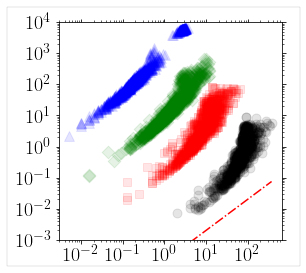

In [29]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [300,600,700,800,900],24,
#       [0,1,2,3,4,5],24,
        [0,3,4,5],[24,44,60,144],
#        [300],8,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( 
#                ['avlStats/scatter_st.txt']
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s_highResolution/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )

    temp.Concatenate()
    
#     #--- plot
    temp.PlotScatter(shift=True, shift_factor=10,
                    rescale=False,alpha=-1.0,
                    powerlaw=True, prefact=2e-4,
                     **{
                  'attrs':{'fmt':'-.r'},
                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(8e-6,2e-3),
                    'ylim':(1e-3,1e4),
                    'ndecade_y':1,
                   'title':'png/scatter_st_E1-4.png',
#                   'title':'png/scatter_st_T300-900K.png',
        'bbox_to_anchor':(0.52,0.02,0.5,0.5)
    })
main()

### size pdf

mkdir: png: File exists


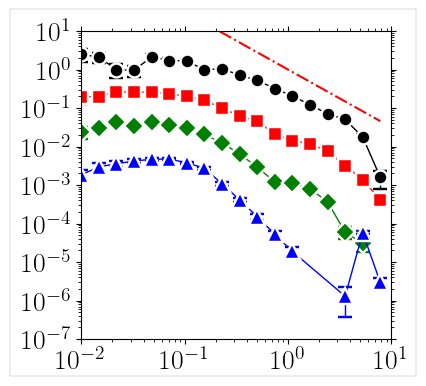

In [171]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [300,600,700,800,900],24,
#       [0,1,2,3,4,5],24,
#       [0,8,32,128],1,
        [0,3,4,5],[24,44,60,144],
#         verbose = True,
                     )


    #--- parse data
    temp.Parse( 
#                ['avlStats/pdf_s.txt']
#                list(map(lambda x:'avlStats/%s/pdf_s_k%s.txt'%(x[0],x[0]),
#                list(map(lambda x:'tensileCantor_tensile900_rate4_kernels/kernel%s/Run0/avlStats/pdf_s.txt'%(x[0]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s_highResolution/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
#                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
        temp.temps_runs ))
    )
        
    temp.EnsAverage()
    
#     #--- fit power-law
#     try:
#         temp.Fit(Plot=True,
#                  shift=True,
#                 p0=[[1.0, 0.01, 2.0, 2.0 ]],
# #                 sigma=True,
# #                 xlo=2e-4,
#                  plotAttrs={'yscale':'log',
#                       'xscale':'log',
#     #                   'xlim':(4e-13,8e-4),
#     #                   'ylim':(1e-2,1e10),
#                        'ylim':(1e-4,1e1),
#                         'ndecade_y':1,'ndecade_x':1,
#                         'nevery':1,
#                         'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
#                        'title':'png/msd_temp_niChoi_fit.png'
#                            },
#                 )
#     except:
#         traceback.print_exc()
#         pass
    
     #--- plot
    temp.PlotPdf(shift=True,shift_factor=0.1,
                 rescale=False,alpha=1.5,
                 powerlaw=True, prefact=1e0,
                 **{
                  'attrs':{'fmt':'-.r'},
                  'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-2,10),
                    'ylim':(1e-7,1e1),
#                    'ylim':(1e-3,4e4),
                    'ndecade_y':1,'ndecade_x':1,
                    'nevery':1,
#                   'title':'png/pdf_s_T300-900K.png',
                   'title':'png/pdf_s_E1-4.png',
#                   'title':'png/pdf_s_E4_kernels.png',
        'bbox_to_anchor':(-0.16,-0.07,0.5,0.5),
    
    })
    
    #--- plot legends
#     temp.PlotPdf(
#                  mylegends=[r'$0$',r'$10$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$'],
#                  **{
#                    'xlim':(1e5,1e5),
#                      'fullopen':True,
#                    'title':'png/pdf_s_E4_kernels_legend.png',
# #                   'title':'png/legend_T300-900K.png',
# #        'bbox_to_anchor':(.46,0.35,0.5,0.5),
#         'bbox_to_anchor':(.34,0.4,0.5,0.5),
#                      'DrawFrame':(-0.5,-0.1,-0.3,-0.1,0.1),

#     })

main()

### ps evolution  

mkdir: cannot create directory ‘png’: File exists


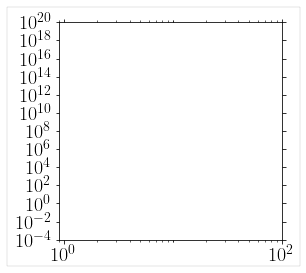

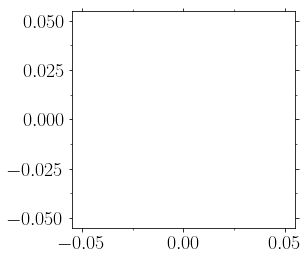

In [21]:
class TemperatureTimeSeries:
    
    def __init__(self,path,verbose=False):
        self.path = path
        self.verbose = verbose

    def Parse(self,**kwargs):
        list_dir = os.listdir(self.path)
        if self.verbose:
            print('list_dir:',list_dir)
        self.data=list(map(lambda x:json.load(open('%s/%s'%(self.path,x),'r')),list_dir))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.keys()),self.data))

        self.col_x = 'bin_edges' if not 'col_x' in kwargs else kwargs['col_x']
        self.col_y = 'hist' if not 'col_y' in kwargs else kwargs['col_y']
        self.col_err = 'error' if not 'col_err' in kwargs else kwargs['col_err']

        
    def GetStrain(self):
        return list(map(lambda x:x['strain_i'],self.data))

    def GetTimeStep(self):
        return list(map(lambda x:x['timestep_i'],self.data))
    
    def Filtr(self,**kwargs):
        n=len(self.data)
        filtr = np.ones(n,dtype=bool)
        if 'strain_lo' in kwargs:
            strains = self.GetStrain()
            filtr_strain_lo = np.array(strains)>kwargs['strain_lo']
            filtr = np.all([filtr,filtr_strain_lo],axis=0)
        if 'strain_hi' in kwargs:
            strains = self.GetStrain()
            filtr_strain_hi = np.array(strains)<kwargs['strain_hi']
            filtr = np.all([filtr,filtr_strain_hi],axis=0)
        print(filtr)
        self.data = np.array(self.data)[filtr]
        
    def Plot(self,
             mylegends='',
             **kwargs):
        
        symbols=Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )

        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        
        for data, count in zip(self.data,range(len(self.data))):
            text = mylegends[count] if not mylegends == '' else ' '
            try:
                utl.PltErr(data[self.col_x],data[self.col_y],
                        yerr=data[self.col_err],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1,label=r'%s'%text),
                       Plot=False,
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs, #legend=legends.Get(),
                   **kwargs
                  )

    def func2nd(self,x,k,x0,xc,alpha,beta):
        return k*np.exp(-(x/xc)**beta)/(1+(x/x0)**alpha)

    def Fit(self,Plot=None,
            shift = False,
            plotAttrs={},
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            mylegends='',
            **kwargs):
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for data, count in zip(self.data,range(len(self.data))):
            text = data['strain_i'] #mylegends[count] if not mylegends == '' else ' '

            xdata = np.array(data[ self.col_x ])
            ydata =np.array(data[ self.col_y ])
            yerr  = np.array(data[ self.col_err ])

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('popt=y0,c0,alpha',list(popt),pcov)
            alpha=popt[3]
            err_alpha = pcov[3,3]**0.5
            self.exponent[text] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                text = mylegends[count] if not mylegends == '' else ' '
                #---fit
                shift_factor = 100**count if shift else 1
                utl.PltErr(xdata,
                                (self.func2nd(xdata,*popt))*shift_factor,#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata,
                           ydata*shift_factor,#-y0)/xdata_shift,
                           yerr=yerr*shift_factor,#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,fmt='.',**plotAttrs),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            attrs = {} if mylegends == '' else {'legend':legends.Get()}
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs,
                       **attrs
                      )
            
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    myPrint = TemperatureTimeSeries(path='./avlStats/json',
#                               verbose=True
                               )
    myPrint.Parse(col_x='edge',col_y='hist',col_err='err')
#     myPrint.Plot(
#                 xscale='log',yscale='log'
#                 )

    #--- fit power-law
    myPrint.Fit(Plot=True,
             shift=True,
            p0=[[1e3, 1e-5, 0.1, 1, 2 ]],
             sigma=True, #--- comment for ni
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                   'xlim':(4e-13,8e-4),
#                   'ylim':(1e-2,1e10),
                   'ylim':(1e-4,1e20),
                    'ndecade_y':2,'ndecade_x':2,
                    'nevery':2,
                    'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
                   'title':'png/msd_temp_niChoi_fit.png'
                       },
            )
    
    utl.PltErr(list(myPrint.exponent.keys()),
               list(map(lambda x:myPrint.exponent[x][0],myPrint.exponent.keys())),
               attrs={'fmt':'.'}
              )
               

main()

### duration

mkdir: png: File exists


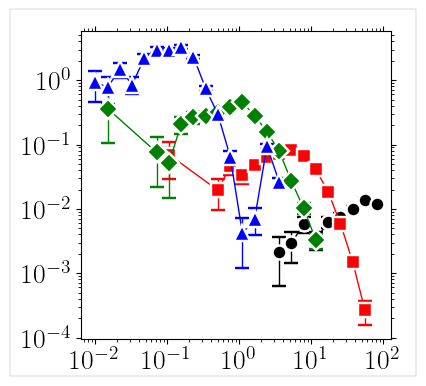

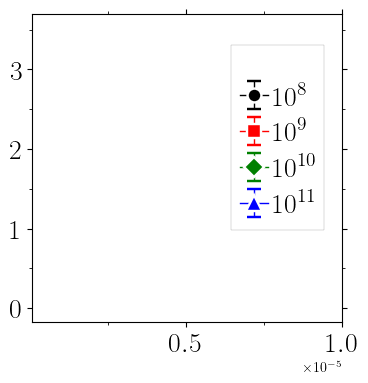

In [183]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [5,300,600,700,900],1,
#       [300,600,700,800,900],24,
        [0,3,4,5],[24,44,60,144],
#       [0,1,2,3],24,
#       [300],24,
#         verbose = True,
                     )
    #
    temp.Parse( 
#                ['avlStats/scatter_st.txt'] 
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s_highResolution/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
#                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
    temp.EnsAverage()

    #--- plot
    temp.PlotPdf(shift=False,shift_factor=10,
                 **{
                  'xscale':'log',
                  'yscale':'log',
#                  'xlim':(1e0,1e2),
#                    'ylim':(1e-2,1e12),
                    'ndecade_y':1,
                   'title':'png/pdf_dur_E1-4.png',
#                   'title':'png/pdf_dur_T300-900K.png',
    })

    #--- plot legends
    temp.PlotPdf(
                     mylegends=[r'$10^{8}$',r'$10^{9}$',r'$10^{10}$',r'$10^{11}$'],
#                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                 **{
                   'xlim':(1e-7,1e-5),
                     'fullopen':True,
                   'title':'png/legend_E1-4.png',
#                   'title':'png/legend_T300-900K.png',
        'bbox_to_anchor':(.5,0.35,0.5,0.5),
#        'bbox_to_anchor':(.35,0.35,0.5,0.5),
        'labelspacing':.4,
        'DrawFrame':(-0.64,-0.06,-0.3,-0.1,0.1),

    })

main()

# Dislocation analysis
## class Defects

In [243]:
class Defects(Statistics):
    '''
    performs dislocation and phase analysis of input crystals
    '''
    StructureType=[0.0,1.0,2.0,3.0,4.0,5.0] #--- hard coded based on ovito's structure types
    
    def __init__(self,path,verbose=False):
        Statistics.__init__(self,path,verbose)
        if self.verbose:
            print('calss Defects constructor call')

        
    def CrysPhase(self,fp,output_path):
        '''
        dump phase information
        
        '''
        if self.verbose:
            print('dxa analysis ...')

        os.system('mkdir -p %s/dislocations/mydislocations'%output_path)
        #--- run ovitos
        input_file='%s/%s'%(self.path,fp)
#        pdb.set_trace()
#        print('output_path=',output_path)
        nevery = int(parser['dislocation analysis']['nevery'])
        os.system('ovitos %s/OvitosCna.py %s mydislocations %s 5'%\
                  (parser['py library directory']['path'],input_file,nevery))
        !mv mydislocations.*  $output_path/dislocations/mydislocations
        
        #--- cna analysis (dxa gives no bcc!)
        os.system('ovitos %s/OvitosCna.py %s %s/dislocations/mydislocations/cna_output.xyz %s 0'%\
                  (parser['py library directory']['path'],input_file,output_path,nevery))


    def ParseDump(self,fp,ncount=sys.maxsize):
        if self.verbose:
            print('parsing %s:'%(fp))
        self.lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=ncount)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            print('times:%s'%keys)
            display(self.lmpData.coord_atoms_broken[keys[0]])

    def Density(self,fout,header):
        if self.verbose:
            print('write in:',fout)
        keys = list(self.lmpData.coord_atoms_broken.keys())
        keys.sort()
        ratios = np.c_[list(map(lambda x:Defects.phaseDensity(self.lmpData.coord_atoms_broken[x]),keys))]
        strains = self.strains = Defects.Strain(self.lmpData)
        #--- write
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[keys,strains,ratios],header=header)

    def BinaryMatrix(self):
        '''
        returns a binary matrix of clusters
        '''
        !mkdir -p dislocations/BinaryMatrix 
        times = list(self.lmpData.coord_atoms_broken.keys())
        times.sort()
        #--- loop over timesteps
        for time, indx in zip(times,range(len(times))):
#        for time, indx in zip(times,range(3)):
            if self.verbose:
                print('print BinaryMatrix%s.json'%time)
            with open("dislocations/BinaryMatrix/BinaryMatrix%s.json"%indx, "w") as outfile:
                xlin,ylin,zlin,mask = Defects.Mask(self.lmpData.coord_atoms_broken[time],
                                                   self.lmpData.BoxBounds[time]
                                                  )
                #--- output as json
                dictionary={'x':list(xlin),'y':list(ylin),'z':list(zlin),
                            'val':list(mask.flatten().astype(float)),
                            'timestep':time}
                json.dump(dictionary, outfile)
            
            
    @staticmethod
    def Mask(lmpData,BoxBounds,Plot=False):
        '''
        returns binary density matrix 
        '''
        #--- fetch data
        dmin_log = (lmpData['StructureType'] == 2).astype(int) #--- hcp phase
        atom = lp.Atoms(**(lmpData))
        box  = lp.Box( BoxBounds = BoxBounds,  
                      AddMissing = np.array([0.0,0.0,0.0] ))
        atom.tmp = list(dmin_log)
         #-----------------
         #--- INTERPOLATE
         #-----------------
        (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'tmp',
                    Plot = None, method='nearest', #dx=1.0,
                   )
        #--- plot
        value = utl.PltBinary(
                            xlin,ylin,zlin, mu_intrp.tmp,
                            box,
                            0.0, #--- threshold
                            cmap='Greys',
                            zscore=False,
                            xlabel = 'x', ylabel = 'y',
                            labels = True,
                            Plot=Plot,
                         )

        mask = value > 0 #quantile(list(value.flatten()),0.95)
        return xlin,ylin,zlin,mask
            
    @staticmethod
    def phaseDensity(df):
        return np.sum(np.c_[list(map(lambda x:df.StructureType == x, Defects.StructureType))].T,axis=0)/float(df.shape[0])

    @staticmethod
    def Strain(lmpData):
        keys = list(lmpData.coord_atoms_broken.keys())
        keys.sort()
        assert len(keys) > 1
        
        itime0 = keys[ 0 ]
        itime  = keys[ 1 ]
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        #
        dl =(box.CellVector[:,2][2] - box0.CellVector[:,2][2])
        dl /= (itime-itime0)
        #
        L0 = box0.CellVector[:,2][2] - itime0 * dl
        L = L0 + dl * np.array(keys)
        #
#        epsilon = (box.CellVector[:,2][2] / box0.CellVector[:,2][2]) - 1.0
#        epsilon /= (itime-itime0)
#        print('strain=',L0,dl,dl/L0)
        return L/L0-1 #epsilon*np.array(keys)



## main function

In [254]:
def main():
    if not eval(parser['dislocation analysis']['dislocationAnalysis']):
        return
    
    try:
        !rm -r dislocations
    except:
        pass
    #--- constructor call
    defect = Defects(path = parser['test data directory']['path'],
                     verbose=True)

    #--- dislocation analysis
    output_path = parser['dislocation analysis']['outputPath']
    defect.CrysPhase(fp=parser['dislocation analysis']['input_file'],
                    output_path=output_path
                    )

    #--- parse dump file
    defect.ParseDump(fp='%s/dislocations/mydislocations/mydislocations.xyz'%\
                     output_path)

    #--- hcp density
    defect.Density(fout='%s/dislocations/structureTypeFraction.txt'%output_path,
                  header='itime ezz other fcc hcp bcc cubicDiamond hexDiamond')

#     #--- redo for cna data
    Defects.StructureType = [0.0,1.0,2.0,3.0,4.0]
    defect.ParseDump(fp='%s/dislocations/mydislocations/cna_output.xyz'%output_path)
    defect.Density(fout='%s/dislocations/structureCnaTypeFraction.txt'%output_path,
                  header='itime ezz other fcc hcp bcc ico')

    
    #--- write binary density matrix
#    defect.BinaryMatrix()
        
main()

class Statistics constructor call: inputFiles= ['dumpSheared.gz' 'dumpSheared.xyz']
calss Defects constructor call
dxa analysis ...
InputFile= ../simulations/CantorNatom10KTemp300KMultipleRates/Rate0/Run0/dumpSheared.xyz
num_frames= 2
frame=0
frame=1
InputFile= ../simulations/CantorNatom10KTemp300KMultipleRates/Rate0/Run0/dumpSheared.xyz
num_frames= 2
frame=0
frame=1


'/Users/Home/Library/Jupyter/runtime/kernel-d6514ef6-a18e-4390-9482-55f8a1e87fba.json'

## class MyPrint

In [195]:
class MyPrint(Temperature):
    
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun,verbose)

    def Plot(self,col_x=1,col_y=1,mylegends='',**kwargs):
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )

        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        for temp, count in zip(self.temps,range(len(self.temps))): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_averaged[temp]
            try:
                utl.PltErr(data[:,col_x],data[:,col_y],
#                        yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'%s'%text,**kwargs),
                       Plot=False,
                      )
            except:
                traceback.print_exc()
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs, #legend=legends.Get(),
                   **kwargs
                  )
        
    def EnsAverage(self):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun[indx]]
#            if temp == 300: #--- comment!!
#                data = self.data[kount+8:kount+self.nrun[indx]]
#            if temp == 900: #--- comment!!
#                 data = self.data[kount:kount+8]
            if self.verbose:
                print('data.shape:',np.array(data).shape) 
#            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
#            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            data_reduced = ftl.reduce(MyPrint.myadd,data)
        
            self.data_averaged[ temp ] = data_reduced/self.nrun[indx]
#            if temp == 300:
#                self.data_averaged[ temp ] = data_reduced/16
#            if temp == 900:
#                self.data_averaged[ temp ] = data_reduced/8
            kount += self.nrun[indx]

    @staticmethod
    def myadd(a,b):
        return a+b
    


### hcp ratio

mkdir: png: File exists


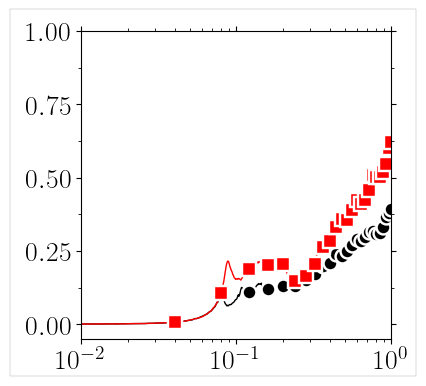

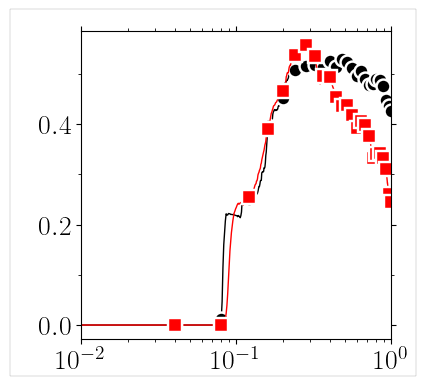

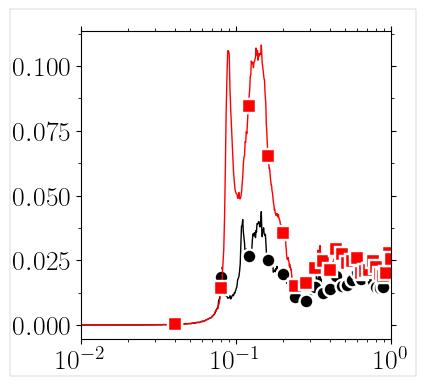

In [267]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    myprint = MyPrint(
#       [4,1,2,3],1,
#       [600,700,800,900],24,
#       [300,600,700,800,900],24,
        [0,3],[24,44],
#         verbose = True,
                     )
    #
    #--- parse data
    myprint.Parse( 
#                ['dislocations/structureTypeFraction.txt'],
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/dislocations/structureTypeFraction.txt'%(x[0],x[1]),
    list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/dislocations/structureCnaTypeFraction.txt'%(x[0],x[1]),
     myprint.temps_runs ))
              )

    myprint.EnsAverage()
    
    #--- plot "other"
    myprint.Plot(col_x=1,col_y=2,
                 **{
                    'xscale':'log',
                     'xlim':(1e-2,1),
                    'ylim':(-0.05,1),
                    'nevery':40,
                   'title':'png/rho_other_T300K_E1-4.png',
#                   'title':'png/rho_other_T300-900K.png',
    })

    
#     myprint.Plot(col_x=1,col_y=3,
#                  **{
#                     'xlim':(0.0,0.1),
#                    'title':'png/rho_fcc_T900K_E1-4.png',
#                     'bbox_to_anchor':(0.5,0.5,0.5,0.5)}
#                 )

    #--- plot "hcp"
    myprint.Plot(col_x=1,col_y=4,
                 **{
                    'xscale':'log',
                     'xlim':(1e-2,1),
                    'nevery':40,
                   'title':'png/rho_hcp_T300K_E1-4.png',
                     'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
    )

    #--- plot "bcc"
    myprint.Plot(col_x=1,col_y=5,
                 **{
                    'xscale':'log',
                     'xlim':(1e-2,1),
                    'nevery':40,
                   'title':'png/rho_bcc_T300K_E1-4.png',
                     'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
    )

    
#
#     myprint.Plot(col_x=1,col_y=5,**{
#                     'xlim':(0.0,0.1),
#                    'title':'png/rho_bcc_T900K_E1-4.png',
# #        'bbox_to_anchor':(0.5,0.01,0.5,0.5)
#     })


main()

In [ ]:
# class Fractal:
#     '''
#     multi-fractal analysis of clusters
#     '''
#     def __init__(self, lmpDmin, lmpData, verbose = False):
#         '''
#         constructor
#         '''
#         self.lmpDmin = lmpDmin
#         self.lmpData = lmpData
#         self.verbose = verbose
        
#         !mkdir fractal
#         pass
    
#     def GetBitmaps(self,times, Plot=False):
#         '''
#         returns a binary matrix of clusters
#         '''
#         #--- loop over timesteps
#         for time in times:
#             #--- fetch data
#             dmin_log = np.log10(self.lmpDmin.coord_atoms_broken[time].d2min)
#             atom = lp.Atoms(**(self.lmpDmin.coord_atoms_broken[time]))
#             box  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#             atom.NonaffineSquaredDisplacement = list(dmin_log)
#              #-----------------
#              #--- INTERPOLATE
#              #-----------------
#             (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
#                         Plot = None,
#                        )
#             #--- plot
#             value = utl.PltBinary(
#                                 xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
#                                 box,
#                                 0.0, #--- threshold
#                                 cmap='Greys',
#             #                    title='ModuAnl/negative_mu.%s.png'%itime,
#                                 zscore=False,
#                                 #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                                 xlabel = 'x', ylabel = 'y',
#                                 labels = True,
#                                 Plot=Plot,
#                              )
#             if self.verbose:
#                 print('value.shape=',value.shape)

#             #---------------------
#             #--- output matrix
#             #---------------------
#             mask = value >= quantile(list(value.flatten()),0.95)
#             if self.verbose:
#                 print('p=',np.sum(mask)/value.size)
#             #--- save
#             np.save('fractal/negative_mu%s'%time,mask)
#             np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
#             np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
#             np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')
            
#     def Strain(self,itime0,itime):
#         #--- strain
#         box = lp.Box(BoxBounds=self.lmpData.BoxBounds[itime0],
#           AddMissing=np.array([0,0,0])
#           )

#         lz0 = box.CellVector[2,2]
#         return lp.Box(BoxBounds=lmpData.BoxBounds[itime],
#                           AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1
               
        
    
#     def func(self,x, a, b):
#         return b * x ** a

#     def FractalDimension(self,pathh,times,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         itime0 = np.min(list(self.lmpData.coord_atoms_broken.keys()))
#         times.sort()
#         Df = []
#         strain= []
#         for time in times:
#             stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                              xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                              ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                              zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                             )
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()
            
#             #--- fit
#             stats.stats.sort_values(by='rg_sq',inplace=True)
            
#             xdata = stats.stats['rg_sq']**0.5
#             ydata = stats.stats['size']
#             filtr = xdata > 0
# #             popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
# #                                    bounds=((0,0),(np.inf,3))
# #                                   )
#             popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                    1
#                                   )
#             popt[1] = 10 ** popt[1]
#             Df += [popt[0]]
#             if self.verbose:
#                 print('df=',popt[0])



#             #--- plot
#             if Plot:
#                 ax=utl.PltErr(xdata,ydata,
#                           attrs={'fmt':'.'},
#                               Plot=False,
#                           )
#                 utl.PltErr(xdata,self.func(xdata, *popt),
#                           attrs={'fmt':'r-.'},
#                           ax=ax,
#                            xscale='log',
#                            yscale='log',
#                            xstr=r'$r_g$',
#                            ystr=r'$s$',
#                            title='fractal/scatter_s_rg.png'
#                           )
                
#             strain += [self.Strain(itime0,time)]    
                
#         utl.PltErr(strain,Df,
#                   xstr=r'$\epsilon_{zz}$',
#                    ystr=r'$d_f$',
#                     title='fractal/df_strain.png'
#                   )

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    
# def main():
    
# # fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # # fractal.GetBitmaps(
# # #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# # #                     Plot=True)
# # fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
# #                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
# #                          Plot=False,
# #                         )
# # # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# # #                     list(lmpDmin.coord_atoms_broken.keys())
# # #                    )

# main


# cluster analysis
+ cluster analysis of top 5% atoms with largest D2min values 

In [29]:
# class Fractal:
#     '''
#     multi-fractal analysis of hcp clusters
#     '''
    
#     def __init__(self,path,nevery,verbose=False):
#         self.path = path
#         self.nevery = nevery
#         self.verbose = verbose

#     def Parse(self):
#         list_dir = os.listdir(self.path)
#         self.data=list(map(lambda x:json.load(open('%s/%s'%(self.path,x),'r')),list_dir))
#         if self.verbose:
#             list(map(lambda x:print('Parsing: data.shape is',x.keys()),self.data))
#             list(map(lambda x:print('timestep:%s'%(x['timestep'])),self.data))


#     def FracDimension(self,fout):
#         '''
#         returns fractal dimesion
#         '''
#         dim = list(map(lambda x:self.ClusterAnalysis(x)['Df'],self.data))
#         times = list(map(lambda x:x['timestep'],self.data))
#         self.dim = Fractal.Sort(dim,times)
#         strain = Fractal.Strain('./dislocations/mydislocations/mydislocations.xyz', 1 )
#         #
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[strain,self.dim],header='ezz df')
        
#     def AutoCorrelation(self,fout):
#         '''
#         return density auto correlations
#         '''
#         data = list(map(lambda x:self.CorrelationAnalysis(x),self.data))
# #         times = list(map(lambda x:x['timestep'],self.data))
# #         strain = Fractal.Strain('./dislocations/mydislocations/mydislocations.xyz')
# #         Fractal.PrintMultipleTimeSteps(fout,times,data,strain)

        
#     def SizeDistribution(self,fout):
#         '''
#         cluster size distribution
#         '''
#         data = list(map(lambda x:self.ClusterAnalysis(x)['ps'],self.data))
#         times = list(map(lambda x:x['timestep'],self.data))
#         strain = Fractal.Strain('./dislocations/mydislocations/mydislocations.xyz', self.nevery )
#         Fractal.PrintMultipleTimeSteps(fout,times,data,strain)

#     def SizeDistributionTotal(self,fout):
#         s = np.concatenate(list(map(lambda x:self.ClusterAnalysis(x)['s'],self.data)))
#         sizeDist = np.c_[utl.GetPDF(s, n_per_decade=6, linscale=None )]
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[sizeDist],header='hist bin_edges error')

#     def Plot(self,mask,xlin,ylin,zlin):
#         #--- print in ovito
#         xv,yv,zv=np.meshgrid(xlin,ylin,zlin)
#         mask_tmp=mask.copy()
#         mask_tmp[:,:,:]=0
#         for idd in list(self.stats.stats['cls_id']): 
#             filtr = self.stats.label_im == int(idd)
#             mask_tmp[filtr]=int(idd)        
#         cordc = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask_tmp.flatten()],columns='x y z mass'.split())
#         sfile=open('dislocations/map.xyz','w')
#         utl.PrintOvito( cordc, sfile, 'atoms', attr_list=['x','y','z','mass'] )

#     def CorrelationAnalysis(self,dictionary,Plot=False):
#         '''
#         returns density auto correlations
#         '''
#         #--- reshape
#         xlin, ylin, zlin, mask = Fractal.Reshape(dictionary)
#         n=len(xlin)
#         xlin=np.arange(-int(n/2),int(n/2)+n%2)
        
#         n=len(ylin)
#         ylin=np.arange(-int(n/2),int(n/2)+n%2)

#         n=len(zlin)
#         zlin=np.arange(-int(n/2),int(n/2)+n%2)
        
#         xv,yv,zv=np.meshgrid(xlin,ylin,zlin)
#         #--- zscore
#         mask -= np.mean(mask)
#         mask /= np.std(mask)
        
#         #---
# #        pdb.set_trace()
#         n = mask.size
#         mask_q = np.fft.fftn(mask)
#         mask_sqmod = (mask_q*mask_q.conjugate()).real
#         crltn = np.fft.ifftn(mask_sqmod).real/n
        
#         #---
#         crltn = np.fft.fftshift(crltn)
        
        
#         cordc = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),crltn.flatten()],columns='x y z mass'.split())
#         sfile=open('dislocations/crltn_map.xyz','w')
#         utl.PrintOvito( cordc, sfile, 'atoms', attr_list=['x','y','z','mass'] )

        
#     def ClusterAnalysis(self,dictionary,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         #--- reshape
#         xlin, ylin, zlin, mask = Fractal.Reshape(dictionary)

#         #--- cluster analysis
#         stats = utl.Stats(mask, 
#                          xlin, 
#                          ylin,
#                          zlin,
#                         )
        
#         #--- store in a dictionary and return
#         df = 0
#         sizeDist=[]
#         s=[]
#         sum_size=0
#         try:
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()

# #            stats.stats.sort_values(by='rg_sq',inplace=True)
#             self.stats = stats
#             self.Plot(mask,xlin,ylin,zlin)
    
#             #--- assign outputs
#             df = Fractal.Get_Df(stats.stats) #--- fractal dimension
#             #
#             filtr = stats.stats.rg_sq > 0.0
#             s=stats.stats.rg_sq[filtr]**0.5
#             sizeDist = np.c_[utl.GetPDF(s, n_per_decade=6, linscale=None )] #--- size distribution
#             #
#             sum_size = stats.stats.size.sum()
#         except:
# #            traceback.print_exc()
#             pass
#         return {'Df':df,'ps':sizeDist,'s':s,'sum_size':sum_size}

#     def GetAccumulatedSize(self,df_avl,fout):
#         '''
#         returns scatter data of stress drop and cluster size
#         '''
#         #--- filter data based on avalanche duration
#         timestep_lohi = np.c_[df_avl[['ti','tf']]]
#         filtr = np.c_[list(map(lambda x:self.Filtr(timestep_lo=x[0],timestep_hi=x[1]),timestep_lohi))]
        
#         #--- integrate
#         accumulatedClusterSize = list(map(lambda x:self.Integrate(x),filtr))

#         EnergyDrop = df_avl['size']
# #        vol=1.0 #--- need volume in the timeseries!!!
# #        EnergyDrop = vol*stressDrop
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[accumulatedClusterSize,EnergyDrop],header='clusterSize EnergyDrop')
        
#     def Filtr(self,**kwargs):
#         '''
#         filter dataset based on timesteps, strains ...
#         '''
#         n=len(self.data)
#         filtr = np.ones(n,dtype=bool)
#         if 'strain_lo' in kwargs:
#             strains = self.GetStrain()
#             filtr_strain_lo = np.array(strains) >= kwargs['strain_lo']
#             filtr = np.all([filtr,filtr_strain_lo],axis=0)
#         if 'strain_hi' in kwargs:
#             strains = self.GetStrain()
#             filtr_strain_hi = np.array(strains) <= kwargs['strain_hi']
#             filtr = np.all([filtr,filtr_strain_hi],axis=0)
#         if 'timestep_lo' in kwargs:
#             times = self.GetTimeStep()
#             filtr_time_lo = np.array(times) >= kwargs['timestep_lo']
#             filtr = np.all([filtr,filtr_time_lo],axis=0)
#         if 'timestep_hi' in kwargs:
#             times = self.GetTimeStep()
#             filtr_time_hi = np.array(times) <= kwargs['timestep_hi']
#             filtr = np.all([filtr,filtr_time_hi],axis=0)
#         return filtr

#     def Integrate(self,filtr0):
#         return np.nan if not np.all(filtr0) else\
#         np.sum(list(map(lambda x:self.ClusterAnalysis(x)['sum_size'],np.array(self.data)[filtr0])))
        
#     def GetStrain(self):
#         return list(map(lambda x:x['strain'],self.data))

#     def GetTimeStep(self):
#         return list(map(lambda x:x['timestep'],self.data))

#     @staticmethod
#     def Reshape(d):
#         nx = len(d['x'])
#         ny = len(d['y'])
#         nz = len(d['z'])
#         val = np.array(d['val']).reshape(ny,nx,nz)
#         return d['x'], d['y'], d['z'], val
    
#     @staticmethod
#     def Get_Df(data_frame):
#         #--- fit

#         xdata = data_frame['rg_sq']**0.5
#         ydata = data_frame['size']
#         filtr = xdata > 0
#         popt, pcov = curve_fit(Fractal.func, xdata[filtr], ydata[filtr],
#                                bounds=((0,0),(np.inf,3))
#                               )
#         popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                1
#                               )
#         return popt[0]
    
#     @staticmethod
#     def func(x, a, b):
#         return b * x ** a

#     @staticmethod
#     def Strain(fp,nevery=1):
#         lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
#         lmpData.GetCords(ncount=sys.maxsize)
#         return Defects.Strain(lmpData)[::nevery]
    
#     @staticmethod
#     def Sort(x,y):
#         slist = list(zip(y, x))
#         slist.sort()
#         return np.array(slist)[:,1]
    
#     @staticmethod
#     def PrintMultipleTimeSteps(fout,times,data, strain):
        
#         for item0, item1, item2, indx in zip(times,data, strain, range(len(times))): 
# #            print('strain=',item1)
#             if len(item1) == 0:
#                 continue
#             with open('%s%s.json'%(fout,indx),'w') as fp:
#                 #--- output as json
#                 dictionary={'hist':list(item1[:,0]),'bin_edges':list(item1[:,1]),'error':list(item1[:,2]),
#                             'strain':item2,'timestep':item0}
#                 json.dump(dictionary, fp)

# def main():
#     if not eval(parser['cluster analysis']['clusterAnalysis']):
#         return
    
#     !mkdir -p ./dislocations/ps

#     #--- feed density bitmaps
#     fractal = Fractal('./dislocations/BinaryMatrix',
#                       nevery = eval(parser['dislocation analysis']['nevery']),
#                       verbose=True
#                      )
    
#     #--- parse data
#     fractal.Parse()

#     #--- statistics of clusters
#     fractal.FracDimension(fout='./dislocations/fractalDimension.txt')
    
#     #--- size distributions
# #    fractal.SizeDistribution(fout='./dislocations/ps/clusterSizePdf') #--- each timestep
# #    fractal.SizeDistributionTotal(fout='./dislocations/ps/clusterSizePdfTotal.txt') #--- total
    
    
#     #--- density correlations
# #    fractal.AutoCorrelation(fout='./dislocations/junk.txt')
    
#     #-----------------------------------------
#     #--- cluster size vs. energy drops:
#     #--- please do the dislocation analysis 
#     #--- with high frequency (i.e. nevery=2)
#     #-----------------------------------------
#     #--- call constructor
# #     stats = Statistics(path = parser['test data directory']['path'],
# #                        verbose=True)

# #     #--- parse dump file
# #     stats.ParseDump(fp=parser['dislocation analysis']['input_file'])
    
# #     #--- parse timeseries
# # #    stats.ParseTimeSeries(fp='thermo.txt',
# # #                         cols=['strain','szz'], #--- comment for different rates
# # #                        )
# #     #--- stress timeseries
# #     stats.GetStressDump()

# #     #--- get avalanches
# #     stats.Avalanche(
# #                     stats.dmpStrs, value='virial',

# #                    )

# #     #--- accumulated size vs. energy drop
# #     fractal.GetAccumulatedSize( stats.df_avl, fout='./dislocations/ps/clusterSizeEnergyDrop.txt' )
    
# main()


Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys([

In [252]:
class Fractal(Statistics):
    '''
    multi-fractal analysis of hcp clusters
    '''
    
    def __init__(self,verbose=False):
        Statistics.__init__(self,path='.',verbose=verbose)
        
        self.verbose = verbose

    def Parse(self,fp):
        self.lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        self.timesteps = np.array(list(self.lmpData.coord_atoms_broken.keys()))
        self.timesteps.sort()
        
        #--- dislocation files
        flist=os.listdir('%s/dislocations/mydislocations'%\
                        parser['dislocation analysis']['outputPath'])
        flist.remove('mydislocations.xyz')
        flist.remove('cna_output.xyz')
        self.frameNumber = np.array(list(map(lambda x:int(x[x.find('.')+1:]),flist)))
        self.frameNumber.sort()

    def SizeDistribution(self,fout):
        '''
        cluster size distribution
        '''
        
        #--- analysis of clusters
        data = list(map(lambda x:
                             self.ClusterAnalysis(self.lmpData.coord_atoms_broken[x[0]],
                                                  lp.Box(BoxBounds=self.lmpData.BoxBounds[x[0]],AddMissing=np.array([0,0,0])),
                                                  x[1])['ps'],
                             zip(self.timesteps,self.frameNumber)))
        strains = Defects.Strain(self.lmpData) 
        #--- write
        Fractal.PrintMultipleTimeSteps(fout,self.timesteps,data,strains)        

        
    def SizeDistributionTotal(self,fout):
        s = np.concatenate(list(map(lambda x:
                                    self.ClusterAnalysis(self.lmpData.coord_atoms_broken[x[0]],
                                                         lp.Box(BoxBounds=self.lmpData.BoxBounds[x[0]],AddMissing=np.array([0,0,0])),
                                                         x[1])['s'],
                                    zip(self.timesteps,self.frameNumber))))
        #--- size distribution                    
        self.SizeDist(sizes=s,
                       fout=fout,
                       density=False,
                       bins=Statistics.LogBins(eval(parser['cluster analysis']['slo']),
                                               eval(parser['cluster analysis']['shi']),
                                               nbin_per_decade=6),
        )

    def ClusterOrientation(self,fout):
#        pdb.set_trace()
        s = np.concatenate(list(map(lambda x:
                                    self.ClusterAnalysis(self.lmpData.coord_atoms_broken[x[0]],
                                                         lp.Box(BoxBounds=self.lmpData.BoxBounds[x[0]],AddMissing=np.array([0,0,0])),
                                                         x[1])['angle'],
                                    zip(self.timesteps,self.frameNumber))))
        theta = list(map(lambda x:x.real,s))
        phi   = list(map(lambda x:x.imag,s))
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[theta, phi],header='theta phi')


    def Plot(self,mask,xlin,ylin,zlin):
        #--- print in ovito
        xv,yv,zv=np.meshgrid(xlin,ylin,zlin)
        mask_tmp=mask.copy()
        mask_tmp[:,:,:]=0
        for idd in list(self.stats.stats['cls_id']): 
            filtr = self.stats.label_im == int(idd)
            mask_tmp[filtr]=int(idd)        
        cordc = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask_tmp.flatten()],columns='x y z mass'.split())
        sfile=open('dislocations/map.xyz','w')
        utl.PrintOvito( cordc, sfile, 'atoms', attr_list=['x','y','z','mass'] )

    def GetAccumulatedSize(self,stats,fout):
        '''
        returns scatter data of stress drop and cluster size
        '''
        
        
        
        #--- total size per frame
        sum_size = list(map(lambda x:
                    self.ClusterAnalysis(self.lmpData.coord_atoms_broken[x[0]],
                                        lp.Box(BoxBounds=self.lmpData.BoxBounds[x[0]],AddMissing=np.array([0,0,0])),
                                         x[1])['sum_size'],
                    zip(self.timesteps,self.frameNumber)))
        
        #--- energy
        timesteps = stats.loadTimeSeries.step
        #--- assert frames analyzed by dxa are present within the stress timeseries
        new_timesteps = list(map(lambda x:timesteps[timesteps>=x].iloc[0],self.timesteps))
        EnergyDrop = utl.FilterDataFrame(stats.loadTimeSeries, key='step', val=new_timesteps)['pe']

        #--- write
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[sum_size,EnergyDrop],header='clusterSize EnergyDrop')

    @staticmethod
    def RadiusOfGyration(df_clusters,dataFrame,ldim):
        filtr = df_clusters.clusterType == 2 #--- hcp clusters
        cluster_ids = df_clusters[filtr].clusterID

        for cluster_id in cluster_ids:
            filtr = dataFrame.Cluster == cluster_id
            filtrd_frame = dataFrame[filtr]
            #--- unwrap coords
            ref_point = filtrd_frame.iloc[0][['x','y','z']]
            xyz_relative = (np.c_[filtrd_frame[['x','y','z']]].T-np.c_[ref_point]).T
            #--- x, y, z dimensions
#            ldim = [lx, ly, lz]
            for idim in range(3):
                filtr = xyz_relative[:,idim] >= 0.5 * ldim[idim]
                xyz_relative[:,idim][filtr] -= ldim[idim]

                filtr = xyz_relative[:,idim] < -0.5 * ldim[idim]
                xyz_relative[:,idim][filtr] += ldim[idim]
                
                #--- print
                clusterID=cluster_id;
                sfile=open('dislocations/junk%s.xyz'%cluster_id,'w');
                utl.PrintOvito( filtrd_frame, sfile, 'itime 0', attr_list=['x','y','z'] );
                sfile=open('dislocations/junk%s.xyz'%cluster_id,'a');
                utl.PrintOvito( pd.DataFrame(np.c_[xyz_relative],columns='x y z'.split()), sfile, 'itime 1', attr_list=['x','y','z'] );

        
    
    
    def ClusterAnalysis(self,dataFrame,
                        box,
                        frame_number):
        '''
        returns fractal dimension df
        '''
        #--- group atoms within the same cluster
        dict_clusters = dataFrame.groupby(by='Cluster').groups
        #
        cluster_ids = list(dict_clusters.keys())
        #--- dataframe with cluster info: id, size, ...
        df_clusters = pd.DataFrame(np.c_[list(map(lambda x: [x, 
                                  dict_clusters[x].shape[0], 
                                  list(set(dataFrame.iloc[dict_clusters[x]]['StructureType']))[0]
                                 ], cluster_ids))].astype(int),
                                   columns='clusterID Size clusterType'.split())

        #clusterID=4;atom_index_cls1 = dict_clusters[clusterID];sfile=open('dislocations/junk.xyz','w');utl.PrintOvito( dataFrame.iloc[atom_index_cls1], sfile, 'atoms', attr_list=['x','y','z'] );sfile.close()
 
        #--- exclude type 'others'
        filtr = df_clusters.clusterType != 0
        df_clusters = df_clusters[ filtr ]
        if 0 in cluster_ids:
            cluster_ids.remove(0) 

        #--- radius of gyration
#        pdb.set_trace()

        Fractal.RadiusOfGyration(df_clusters,
                                 dataFrame,
                                 box.CellVector.diagonal()
                                )
        
        
        

        #--- read orientations from dislocation files
        ncluster = df_clusters.shape[0] 
        if self.verbose:
            print('frame=%s, ncluster=%s'%(frame_number,ncluster))
            display(df_clusters)
        if ncluster > 0:
            orientation = Fractal.ReadDislocationFile('%s/dislocations/mydislocations/mydislocations.%s'%\
                                                      (parser['dislocation analysis']['outputPath'],frame_number),
                                                     ncluster,
                                                      #verbose=self.verbose
                                                     )

            orientation_reformatted = np.c_[list(map(lambda x:orientation[x][:,2],cluster_ids))]

            #--- include orientation info
            df_clusters = pd.DataFrame(np.c_[df_clusters,orientation_reformatted],
                                       columns = list(df_clusters.keys())+'nx ny nz'.split())        
                

        #--- store in a dictionary and return
        sizeDist=[]
        s = []
        angle = []
        sum_size = 0
        if ncluster > 0:
            #--- assign outputs
            filtr = df_clusters.clusterType == 2 #--- hcp
            if np.sum(filtr) != 0:
                #--- angles
                angle = list(map(lambda x:Fractal.GetPolarAzimuthalAngles(x), 
                                        np.c_[df_clusters[filtr][['nx','ny','nz']]]))+\
                        list(map(lambda x:Fractal.GetPolarAzimuthalAngles(x), 
                                                -np.c_[df_clusters[filtr][['nx','ny','nz']]]))
                #--- size
                s = df_clusters[filtr].Size
                sum_size = s.sum()
                sizeDist = np.c_[utl.GetPDF(s, n_per_decade=6, linscale=None )] #--- size distribution
        return {'ps':sizeDist,'s':s,'angle':angle,'sum_size':sum_size}


    def Filtr(self,**kwargs):
        '''
        filter dataset based on timesteps, strains ...
        '''
        n=len(self.data)
        filtr = np.ones(n,dtype=bool)
        if 'strain_lo' in kwargs:
            strains = self.GetStrain()
            filtr_strain_lo = np.array(strains) >= kwargs['strain_lo']
            filtr = np.all([filtr,filtr_strain_lo],axis=0)
        if 'strain_hi' in kwargs:
            strains = self.GetStrain()
            filtr_strain_hi = np.array(strains) <= kwargs['strain_hi']
            filtr = np.all([filtr,filtr_strain_hi],axis=0)
        if 'timestep_lo' in kwargs:
            times = self.GetTimeStep()
            filtr_time_lo = np.array(times) >= kwargs['timestep_lo']
            filtr = np.all([filtr,filtr_time_lo],axis=0)
        if 'timestep_hi' in kwargs:
            times = self.GetTimeStep()
            filtr_time_hi = np.array(times) <= kwargs['timestep_hi']
            filtr = np.all([filtr,filtr_time_hi],axis=0)
        return filtr

    def Integrate(self,filtr0):
        return np.nan if not np.all(filtr0) else\
        np.sum(list(map(lambda x:self.ClusterAnalysis(x)['sum_size'],np.array(self.data)[filtr0])))
        
    def GetStrain(self):
        return list(map(lambda x:x['strain'],self.data))

    def GetTimeStep(self):
        return list(map(lambda x:x['timestep'],self.data))

    @staticmethod
    def GetPolarAzimuthalAngles(r):
        ez=np.array([0,0,1])
        ex=np.array([1,0,0])
        rz=np.dot(r,ez)*ez
        rp=r-rz
        rzz=np.dot(r,ez)/np.dot(r,r)**0.5
        polar_angle = 180.0*np.arccos(rzz)/np.pi
        azimuth_angle = 180.0*np.arctan2(rp[1],rp[0])/np.pi
        return azimuth_angle + polar_angle *1j

    @staticmethod
    def Reshape(d):
        nx = len(d['x'])
        ny = len(d['y'])
        nz = len(d['z'])
        val = np.array(d['val']).reshape(ny,nx,nz)
        return d['x'], d['y'], d['z'], val
    
    @staticmethod
    def Get_Df(data_frame):
        #--- fit

        xdata = data_frame['rg_sq']**0.5
        ydata = data_frame['size']
        filtr = xdata > 0
        popt, pcov = curve_fit(Fractal.func, xdata[filtr], ydata[filtr],
                               bounds=((0,0),(np.inf,3))
                              )
        popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
                               1
                              )
        return popt[0]
    
    @staticmethod
    def func(x, a, b):
        return b * x ** a
    
    @staticmethod
    def Sort(x,y):
        slist = list(zip(y, x))
        slist.sort()
        return np.array(slist)[:,1]
    
    @staticmethod
    def PrintMultipleTimeSteps(fout,times,data, strain):
        
        for item0, item1, item2, indx in zip(times,data, strain, range(len(times))): 
#            print('strain=',item1)
            if len(item1) == 0:
                continue
            with open('%s%s.json'%(fout,indx),'w') as fp:
                #--- output as json
                dictionary={'hist':list(item1[:,0]),'bin_edges':list(item1[:,1]),'error':list(item1[:,2]),
                            'strain':item2,'timestep':item0}
                json.dump(dictionary, fp)

    @staticmethod
    def ReadDislocationFile(myfile,ncluster,verbose=False):
        #--- read file
#        pdb.set_trace()
        strr=open(myfile).readlines() #--- read as string
        li = strr.index('CLUSTERS %s\n'%ncluster) #--- 1st line to be read
        if verbose:
            print('read line %s '%li)
        li += 1

        orientation = {}
        for ii in range(ncluster): #--- two dislocations
            cluster_id = int(strr[li].split()[1])
            if verbose:
                print('cluster_id=',cluster_id)
            #
            li += 3
            #
            orientation[cluster_id] = np.c_[[list(map(float,strr[li+jj].split())) for jj in range(3)]]
            if verbose:
                print('orientation=',orientation[cluster_id])
            #
            li+=6
        return orientation
                

def main(stats):
    if not eval(parser['cluster analysis']['clusterAnalysis']):
        return
    
    !mkdir -p ./dislocations/ps

    #--- feed density bitmaps
    fractal = Fractal(#verbose=True
                     )
    
    #--- parse data
    fractal.Parse('%s/dislocations/mydislocations/mydislocations.xyz'%\
                  parser['dislocation analysis']['outputPath'])

    
    #--- size distributions
#    fractal.SizeDistribution(fout='./dislocations/ps/clusterSizePdf') #--- each timestep
    fractal.SizeDistributionTotal(fout='%s/dislocations/ps/clusterSizePdfTotal.txt'%\
                                  parser['dislocation analysis']['outputPath']) #--- total
    
    #--- orientation
    fractal.ClusterOrientation(fout='%s/dislocations/ps/clusterOrientationTotal.txt'%\
                               parser['dislocation analysis']['outputPath'])
    
    #-----------------------------------------
    #--- cluster size vs. energy drops:
    #--- please do the dislocation analysis 
    #--- with high frequency (i.e. nevery=2)
    #-----------------------------------------
#    fractal.GetAccumulatedSize(stats, 
#                               fout='./dislocations/ps/clusterSizeEnergyDrop.txt' )


main(stats)


## Print
### fractal dimension

In [14]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    myprint = MyPrint(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
       [300],24,
         verbose = True,
                     )
    #
    #--- parse data
    myprint.Parse( 
#                ['dislocations/fractalDimension.txt']
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
                         myprint.temps_runs ))
              )
    
    myprint.EnsAverage()

    #--- plot
    myprint.Plot(col_x=0,col_y=1,
#                   mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
#                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                 **{
                    'xscale':'log',
                   'title':'png/df_hcp_T900K_E1-4.png',
                     'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
    )
#    print(myprint.data)

main()

mkdir: cannot create directory ‘png’: File exists


OSError: CantorNatom10KTemp300K/Run8/dislocations/fractalDimension.txt not found.

### cluster size distribution
* time evolution

mkdir: png: File exists
list_dir: ['clusterSizePdf6.json', 'clusterSizePdf4.json', 'clusterSizePdf5.json', 'clusterSizePdf2.json', 'clusterSizePdf3.json']
Parsing: data.shape is dict_keys(['hist', 'bin_edges', 'error', 'strain', 'timestep'])
Parsing: data.shape is dict_keys(['hist', 'bin_edges', 'error', 'strain', 'timestep'])
Parsing: data.shape is dict_keys(['hist', 'bin_edges', 'error', 'strain', 'timestep'])
Parsing: data.shape is dict_keys(['hist', 'bin_edges', 'error', 'strain', 'timestep'])
Parsing: data.shape is dict_keys(['hist', 'bin_edges', 'error', 'strain', 'timestep'])
timestep:1800
timestep:1200
timestep:1500
timestep:600
timestep:900


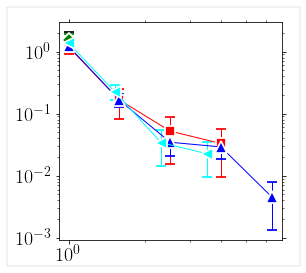

In [109]:
class MyPrintTimeSeries:
    
    def __init__(self,path,verbose=False):
        self.path = path
        self.verbose = verbose

    def Parse(self):
        list_dir = os.listdir(self.path)
        if self.verbose:
            print('list_dir:',list_dir)
        self.data=list(map(lambda x:json.load(open('%s/%s'%(self.path,x),'r')),list_dir))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.keys()),self.data))
            list(map(lambda x:print('timestep:%s'%(x['timestep'])),self.data))



    def GetStrain(self):
        return list(map(lambda x:x['strain'],self.data))

    def GetTimeStep(self):
        return list(map(lambda x:x['timestep'],self.data))
    
    def Filtr(self,**kwargs):
        n=len(self.data)
        filtr = np.ones(n,dtype=bool)
        if 'strain_lo' in kwargs:
            strains = self.GetStrain()
            filtr_strain_lo = np.array(strains)>kwargs['strain_lo']
            filtr = np.all([filtr,filtr_strain_lo],axis=0)
        if 'strain_hi' in kwargs:
            strains = self.GetStrain()
            filtr_strain_hi = np.array(strains)<kwargs['strain_hi']
            filtr = np.all([filtr,filtr_strain_hi],axis=0)
        print(filtr)
        self.data = np.array(self.data)[filtr]
        
    def Plot(self,
             mylegends='',
             **kwargs):
        
        symbols=Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )

        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        for data, count in zip(self.data,range(len(self.data))):
            text = mylegends[count] if not mylegends == '' else ' '
            try:
                utl.PltErr(data['bin_edges'],data['hist'],
                        yerr=data['error'],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1,label=r'%s'%text),
                       Plot=False,
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs, #legend=legends.Get(),
                   **kwargs
                  )

def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    myPrint = MyPrintTimeSeries(path='dislocations/ps/',
                               verbose=True
                               )
    myPrint.Parse()
#    myPrint.Filtr(strain_lo=0.0,strain_hi=10.0)
    myPrint.Plot(xscale='log',yscale='log')
#    pdb.set_trace()
    #--- 
#    myprint = MyPrint(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [0],1,
#         verbose = True,
#                     )
    #
    #--- parse data
#     myprint.Parse( 
#                 ['dislocations/fractalDimension.txt']
# #                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
# #                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
# #                         myprint.temps_runs ))
#               )
# #     #
#      #--- plot

#     myprint.Plot(col_x=0,col_y=1,
# #                   mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
# #                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
#                  **{
#                     'xscale':'log',
#                    'title':'png/df_hcp_T900K_E1-4.png',
#                      'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
#     )
# #    print(myprint.data)

main()

* total

mkdir: png: File exists


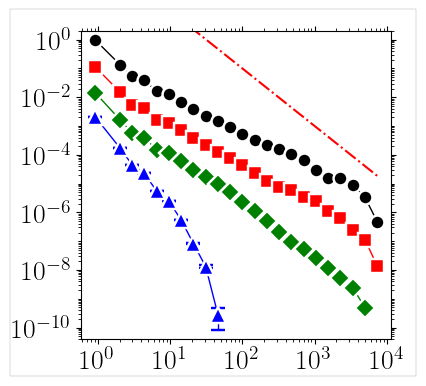

In [57]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
        [0,3,4,5],[24,44,60,144],
#         verbose = True,
                     )
    #--- parse data
    temp.Parse( 
#                ['dislocations/clusterSizePdfTotal.txt']
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/dislocations/clusterSizePdfTotal.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
    temp.EnsAverage()

     #--- plot
    temp.PlotPdf(shift=True,shift_factor=0.1,
                 rescale=False,alpha=2,
                 powerlaw=True, prefact=1e3,
                 **{
                  'attrs':{'fmt':'-.r'},
                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-2,10),
                    'ylim':(4e-11,2),
#                    'ylim':(1e-3,4e4),
                    'ndecade_y':2,'ndecade_x':1,
                    'nevery':1,
#                   'title':'png/pdf_s_T300-900K.png',
                   'title':'png/pdf_cluster_size_E1-4.png',
#                   'title':'png/pdf_s_E4_kernels.png',
        'bbox_to_anchor':(-0.16,-0.07,0.5,0.5),
    
    })

main()

### slip planes

mkdir: png: File exists


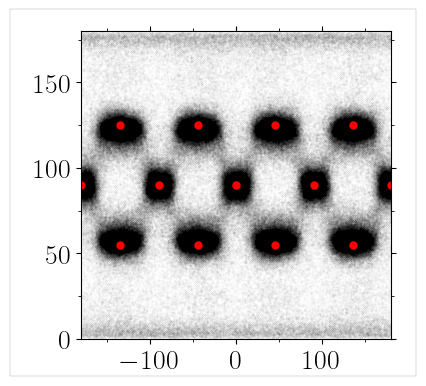

In [121]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [300,600,700,800,900],24,
#       [0,1,2,3,4,5],24,
#        [0,3,4,5],[24,44,60,144],
#        [0],[24],
        [5],[144],
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( 
#                ['dislocations/clusterOrientationTotal.txt']
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s_highResolution/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/dislocations/clusterOrientationTotal.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )

    temp.Concatenate()
    
#     #--- plot
    temp.PlotScatter(shift=False, shift_factor=10,
                    rescale=False,alpha=-1.0,
                    powerlaw=False, prefact=2e-4,
                    markersizes = [.1],
                    transparency=0.04,
                    addPoints=np.array([[45,54.7],[-135,125.3],
                                        [-135,54.7],[45,125.3],
                                        [135,54.7],[-45,125.3],
                                        [-45,54.7],[135,125.3],
                                        [0,90],[90,90],[-90,90],[180,90],[-180,90]
                                       ]),
                     **{
                  'attrs':{'fmt':'-.r'},
#                  'xscale':'log',
#                  'yscale':'log',
                   'xlim':(-180,180),
                    'ylim':(0,180),
                    'ndecade_y':1,
                   'title':'png/scatter_orientation_E4.png',
#                   'title':'png/scatter_st_T300-900K.png',
        'bbox_to_anchor':(0.52,0.02,0.5,0.5)
    })
main()

mkdir: png: File exists


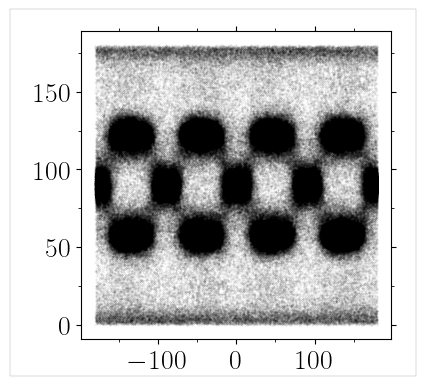

In [99]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [300,600,700,800,900],24,
#       [0,1,2,3,4,5],24,
#        [0,3,4,5],[24,44,60,144],
        [5],[144],
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( 
#                ['dislocations/clusterOrientationTotal.txt']
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantor_tensile900_rate%s_highResolution/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'CantorNatom10KTemp%sK/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/dislocations/clusterOrientationTotal.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )

    temp.Concatenate()
    
#     #--- plot
    temp.PlotScatter(shift=False, shift_factor=10,
                    rescale=False,alpha=-1.0,
                    powerlaw=False, prefact=2e-4,
                    markersizes = [.1],
                     **{
                  'attrs':{'fmt':'-.r'},
#                  'xscale':'log',
#                  'yscale':'log',
#                   'xlim':(8e-6,2e-3),
#                    'ylim':(1e-3,1e4),
                    'ndecade_y':1,
                   'title':'png/scatter_st_E1-4.png',
#                   'title':'png/scatter_st_T300-900K.png',
        'bbox_to_anchor':(0.52,0.02,0.5,0.5)
    })
main()

### energy drop and size

mkdir: png: File exists
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
Parsing: data.shape is (101, 2)
temp:0, data.shape:(2424, 2)


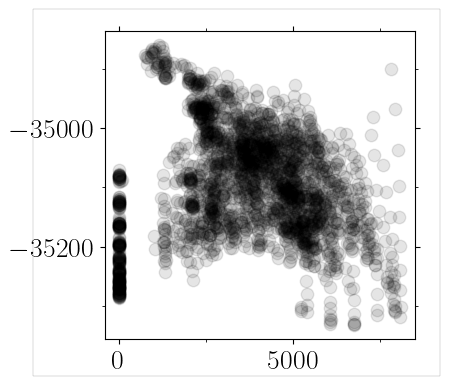

In [140]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
#       [3],1,
#       [300,600,700,800,900],1,
       [0],[24],
         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( 
#                ['avlStats/scatter_st.txt']
                list(map(lambda x:'CantorNatom10KTemp300KMultipleRates/Rate%s/Run%s/dislocations/ps/clusterSizeEnergyDrop.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE8/Run%s/dislocations/ps/clusterSizeEnergyDrop.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
    temp.Concatenate()
    
#     #--- plot
    temp.PlotScatter(shift=False, shift_factor=10,
                    rescale=False,alpha=-1.0,
                    powerlaw=False, prefact=2e-4,
#                    markersizes = [10],
                     **{
                  'attrs':{'fmt':'-.r'},
#                  'xscale':'log',
#                  'yscale':'log',
#                   'xlim':(8e-6,2e-3),
#                    'ylim':(1e-3,1e4),
                    'ndecade_y':1,
                   'title':'png/scatter_st_E1-4.png',
#                   'title':'png/scatter_st_T300-900K.png',
        'bbox_to_anchor':(0.52,0.02,0.5,0.5)
    })
main()


In [ ]:
# class Fractal:
#     '''
#     multi-fractal analysis of clusters
#     '''
#     def __init__(self, lmpDmin, lmpData, verbose = False):
#         '''
#         constructor
#         '''
#         self.lmpDmin = lmpDmin
#         self.lmpData = lmpData
#         self.verbose = verbose
        
#         !mkdir fractal
#         pass
    
#     def GetBitmaps(self,times, Plot=False):
#         '''
#         returns a binary matrix of clusters
#         '''
#         #--- loop over timesteps
#         for time in times:
#             #--- fetch data
#             dmin_log = np.log10(self.lmpDmin.coord_atoms_broken[time].d2min)
#             atom = lp.Atoms(**(self.lmpDmin.coord_atoms_broken[time]))
#             box  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#             atom.NonaffineSquaredDisplacement = list(dmin_log)
#              #-----------------
#              #--- INTERPOLATE
#              #-----------------
#             (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
#                         Plot = None,
#                        )
#             #--- plot
#             value = utl.PltBinary(
#                                 xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
#                                 box,
#                                 0.0, #--- threshold
#                                 cmap='Greys',
#             #                    title='ModuAnl/negative_mu.%s.png'%itime,
#                                 zscore=False,
#                                 #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                                 xlabel = 'x', ylabel = 'y',
#                                 labels = True,
#                                 Plot=Plot,
#                              )
#             if self.verbose:
#                 print('value.shape=',value.shape)

#             #---------------------
#             #--- output matrix
#             #---------------------
#             mask = value >= quantile(list(value.flatten()),0.95)
#             if self.verbose:
#                 print('p=',np.sum(mask)/value.size)
#             #--- save
#             np.save('fractal/negative_mu%s'%time,mask)
#             np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
#             np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
#             np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')
            
#     def Strain(self,itime0,itime):
#         #--- strain
#         box = lp.Box(BoxBounds=self.lmpData.BoxBounds[itime0],
#           AddMissing=np.array([0,0,0])
#           )

#         lz0 = box.CellVector[2,2]
#         return lp.Box(BoxBounds=lmpData.BoxBounds[itime],
#                           AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1
               
        
    
#     def func(self,x, a, b):
#         return b * x ** a

#     def FractalDimension(self,pathh,times,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         itime0 = np.min(list(self.lmpData.coord_atoms_broken.keys()))
#         times.sort()
#         Df = []
#         strain= []
#         for time in times:
#             stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                              xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                              ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                              zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                             )
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()
            
#             #--- fit
#             stats.stats.sort_values(by='rg_sq',inplace=True)
            
#             xdata = stats.stats['rg_sq']**0.5
#             ydata = stats.stats['size']
#             filtr = xdata > 0
# #             popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
# #                                    bounds=((0,0),(np.inf,3))
# #                                   )
#             popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                    1
#                                   )
#             popt[1] = 10 ** popt[1]
#             Df += [popt[0]]
#             if self.verbose:
#                 print('df=',popt[0])



#             #--- plot
#             if Plot:
#                 ax=utl.PltErr(xdata,ydata,
#                           attrs={'fmt':'.'},
#                               Plot=False,
#                           )
#                 utl.PltErr(xdata,self.func(xdata, *popt),
#                           attrs={'fmt':'r-.'},
#                           ax=ax,
#                            xscale='log',
#                            yscale='log',
#                            xstr=r'$r_g$',
#                            ystr=r'$s$',
#                            title='fractal/scatter_s_rg.png'
#                           )
                
#             strain += [self.Strain(itime0,time)]    
                
#         utl.PltErr(strain,Df,
#                   xstr=r'$\epsilon_{zz}$',
#                    ystr=r'$d_f$',
#                     title='fractal/df_strain.png'
#                   )

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    
# def main():
    
# # fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # # fractal.GetBitmaps(
# # #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# # #                     Plot=True)
# # fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
# #                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
# #                          Plot=False,
# #                         )
# # # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# # #                     list(lmpDmin.coord_atoms_broken.keys())
# # #                    )

# main


In [ ]:
# fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # fractal.GetBitmaps(
# #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# #                     Plot=True)
# fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
#                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
#                          Plot=False,
#                         )
# # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# #                     list(lmpDmin.coord_atoms_broken.keys())
# #                    )


In [ ]:
# #--- timesteps
# keys = list(lmpData.coord_atoms_broken.keys())
# keys.sort()

# #--- stress
# szz = list(map(lambda x:lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys))

# #--- strain
# box = lp.Box(BoxBounds=lmpData.BoxBounds[keys[0]],
#       AddMissing=np.array([0,0,0])
#       )

# lz0 = box.CellVector[2,2]
# ezz = list(map(lambda x:lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1,
#                keys))

# #--- volume
# vol = list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector),
#                keys))

# dmpStrs=pd.DataFrame(np.c_[keys,np.array(ezz+ezz[1]-ezz[0]),1e-4*np.array(szz)/vol],columns=['timestep','strain','szz'])

# #--- plot
# symbols=Symbols()
# ax=utl.PltErr(None,#loadTimeSeries['strain'],
#           None,#loadTimeSeries['szz'],
#            fmt='-',
#               Plot=False,
          
#           )
# utl.PltErr(dmpStrs.strain,dmpStrs.szz,
# #            attrs=symbols.GetAttrs(count=0,fmt='.-'),
#            attrs={'fmt':'-','color':'C0'},
#           ax=ax,
#             xlim=(0.0,1.0),
# #            ylim=(2,3)
#            xstr=r'$\epsilon_{zz}$',
#            ystr=r'$\sigma_{zz}(\mathrm{Gpa})$',
#            title='png/stress_strain.png'
#           )



### strain map

In [ ]:
# #--- strain window
# tif=df_avl.iloc[0][['ei','ef']]
# filtr=np.all([dmpStrs['strain']<tif['ef'],dmpStrs['strain']>=tif['ei']],axis=0)
# # #--- load
# flo = 0.99*dmpStrs['szz'][filtr].min()
# fhi = 1.01*dmpStrs['szz'][filtr].max() #ld.Force.max()

# #--- load vs. time
# ydata = loadTimeSeries
# utl.PltErr(ydata.strain, ydata.szz,
#            attrs={'fmt':'-'},
#             xlim=(tif['ei'],tif['ef']),
#             ylim=(flo,fhi),
#            xstr=r'$\epsilon$',
#            ystr=r'$\sigma$',
#           )

### local strain

In [ ]:
# def WrapperStrain(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke strain analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         lp.WriteDumpFile(atom_current, box).Write('strain/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')

#         lp.WriteDumpFile(atom_reference, box0).Write('strain/dump_ref.xyz', itime=ii0,
#              attrs=['id', 'type','x', 'y', 'z'],
#              fmt='%i %i %15.14e %15.14e %15.14e')
#         fileCurr = 'strain/dump_curr.xyz'
#         fileRef = 'strain/dump_ref.xyz'
#         output = 'strain/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 5 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> strain/strain.xyz;rm %s'%(output,output))

        
# !mkdir strain
# try:
#     os.system('rm strain/strain.xyz')
# except:
#     pass
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperStrain(lmpData,reference_frames,current_frames)

# #--- parse
# lmpStrn = lp.ReadDumpFile( 'strain/strain.xyz' )
# lmpStrn.GetCords( ncount = sys.maxsize )

### d2min

In [ ]:
# def WrapperD2min(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke d2min analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         if dim == 3:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#         else:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#     #    os.system('tar czf dump.gz dump.xyz')
#         fileCurr = 'D2minAnl/dump_curr.xyz'
#         fileRef = 'D2minAnl/dump_ref.xyz'
#         output = 'D2minAnl/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 2 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> D2minAnl/d2min.xyz;rm %s'%(output,output))

        
        
        
# #    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease nevery!'
# !mkdir D2minAnl
# try:
#     os.system('rm D2minAnl/d2min.xyz')
# except:
#     pass

# #--- assign frames
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperD2min(lmpData,reference_frames,current_frames)
# #--- parse
# lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
# lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

### plot

In [ ]:
# def quantile(slist,q):
#     slist.sort()
#     n=len(slist)
#     return slist[int(q*n):][0]


# #--- print 
# !rm D2minAnl/d2min_avalanche.xyz
# keys=list(lmpDmin.coord_atoms_broken.keys())
# keys.sort()
# sfile=open('D2minAnl/d2min_avalanche.xyz','a')
# for time in keys:
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
# sfile.close()

### vary threshold

In [ ]:
# def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
#     return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc)['size'], loadTimeSeries)))

# legend=Legends()
# legend.Set(fontsize=16,
#                  labelspacing=0,
#                  bbox_to_anchor=(1,0.48,0.5,0.5),
#            )
# #
# alpha=1.0
# #
# lambdc = np.logspace(np.log10(1.0e-3),np.log10(1.0e2),6)
# size_lambdc = list(map(lambda x:varyThreshold([loadTimeSeries[0]], tlo, thi, x),lambdc))

# #--- distributions
# hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))

# ax = utl.PltErr(None,None,Plot=False)
# for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
#     hist, edge, err = item
#     ax=utl.PltErr(edge, 
#                   10**indx*hist,#*edge**alpha, 
#                   yerr=10**indx*err,#*edge**alpha,
#                    attrs=symbols.GetAttrs(count=indx%7,label=r'$%2.1e$'%threshold),
#                     Plot = False,
#                     ax=ax,
#                   )
# utl.PltErr(None,None,
# #    edge, 1e-1/edge**alpha,
# #           attrs={'fmt':'-.r'},
#             legend=legend.Get(),
# #           ystr=r'$P(s).s^{%s}$'%alpha,xstr=r'$s$',
#            ystr=r'$P(s)$',xstr=r'$s$',
#            xscale = 'log',yscale='log',
#            xlim=(1.0e-6,.2),ylim=(1e-1,1e8), #hist.min(),hist.min()*1e8),
#            ax=ax,
#            title='png/ps.png',
#           )

In [ ]:
# def func(x, a, b, c):
#     return a * x**b * np.exp(-c * x)
# def func2(x, a, b):
#     return a * x**b

# xdata = edge
# ydata = hist
# yerr=err
# ax = utl.PltErr(xdata, ydata, yerr=yerr, label='data',Plot=False)
# popt, pcov = curve_fit(func, xdata, ydata,
#                       bounds=((1e-3,-4,1e-3), (np.infty, 0, 100.0)),
#                        p0=(1,-1,10.0),
#                        sigma=err,
#                       )
# print(popt)
# utl.PltErr(xdata, func(xdata, *popt), attrs={'fmt':'r-'},
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt),
#         ax=ax,
#            xscale='log',yscale='log',
#           )



In [ ]:
# input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
# grain_attr = pd.read_csv(input_file,sep='\t')
# grain_attr.head()

In [ ]:
# def Wrapper(index):
#     #index = 0 #--- file index
#     ld = loadTimeSeries[ index ] #--- file id
#     indentLabel = indentLabels[index]

#     grainLabel = grainLabels[loadID][indentLabel]
#     print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

#     lambdc = 10.0
#     avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
#     moment_1st = np.mean(avlanche)
#     avalanche_sq = avlanche*avlanche
#     moment_2nd = np.mean(avalanche_sq)**0.5
#     avalanche_4th = avalanche_sq*avalanche_sq
#     moment_4th = np.mean(avalanche_4th)**0.25

#     grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
# #    pdb.set_trace()
#     return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


# #val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'1st moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'2nd moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )
# # utl.PltErr(val[:,0],val[:,2],
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'avalanche size(2nd moment)',
# #            title='avalancheSize.png'
# # #           xlim=(-3,3),
# # #           ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'4th moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )


In [ ]:
# df = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask.flatten()],columns=['x','y','z','mass'])
# utl.PrintOvito( df,
#                open('ovito.xyz','w'),
#                'itime=0',
#                 attr_list=['x', 'y', 'z','mass'],

#             )

In [ ]:
#     sfile=open('dump.xyz','w')
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
#     sfile.close()